<a href="https://colab.research.google.com/github/UDICatNCHU/PyTorch-Tutorial/blob/master/Lession_6_BERT_MLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Input Encoding/Representation




In [1]:
!pip install transformers
from transformers import BertTokenizer, BertForMaskedLM
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

     |████████████████████████████████| 1.3MB 7.2MB/s 
     |████████████████████████████████| 1.1MB 20.7MB/s 
     |████████████████████████████████| 2.9MB 38.6MB/s 
     |████████████████████████████████| 890kB 43.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c600055f92c75f05371db838536474ecd7b3ae9ded257047ab23a279f00b5113
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


###### Single Sentence Embedding

In [ ]:
encoding = tokenizer(["I love you"])

In [ ]:
print(encoding)

{'input_ids': [[101, 1045, 2293, 2017, 102], [101, 20315, 102]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1]]}


In [ ]:
encoding['input_ids']

[[101, 1045, 2293, 2017, 102]]

In [ ]:
tokenizer.decode(encoding['input_ids'][0])

'[CLS] i love you [SEP]'

###### Sentence Pair Embedding

In [ ]:
two_sentences_encoding = tokenizer(["my dog is cute"], ["he likes playing"])

In [ ]:
tokenizer.decode(two_sentences_encoding['input_ids'][0])

'[CLS] my dog is cute [SEP] he likes playing [SEP]'

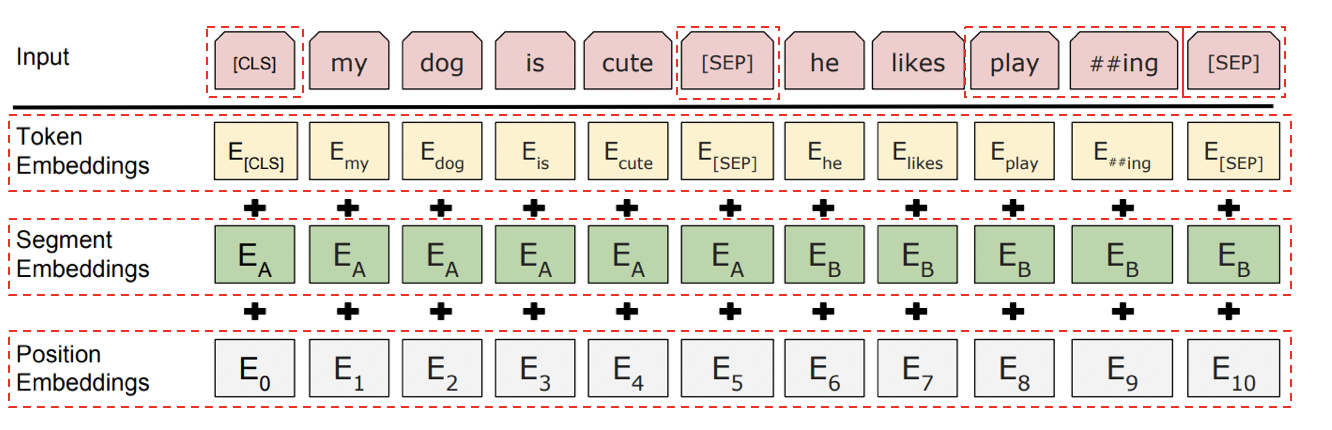

# Mimimum Runable Code Piece (MRCP) 最核心BERT程式 Masked-LM執行片段

In [3]:
from transformers import BertTokenizer, BertForMaskedLM, AdamW
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


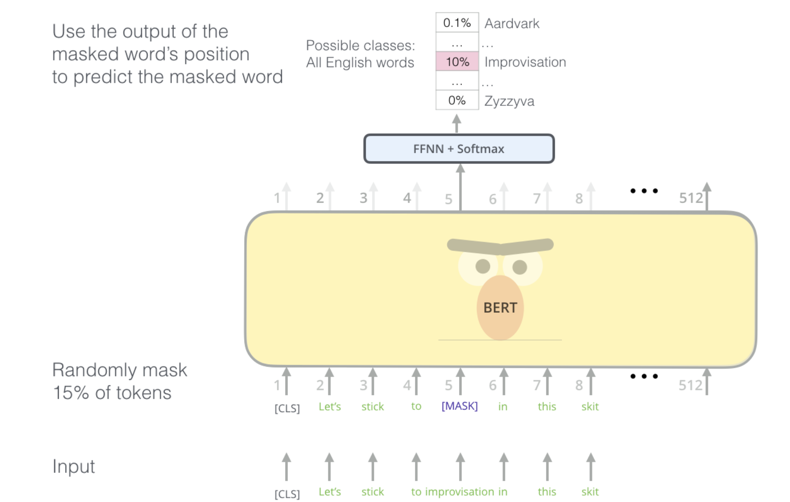

In [4]:
inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")
labels = tokenizer("The capital of France is Pair.", return_tensors="pt")["input_ids"]
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits
print(tokenizer.decode(torch.argmax(logits[0], dim=1)))

. the capital of france is paris..


### 請想想看logits的shape是怎樣？為何會是30522

In [ ]:
logits.shape

torch.Size([1, 9, 30522])

### A glance for how BERT training is proceeded 一窺最基本的BERT訓練流程

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, AdamW
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

for epoch in [0,1,2,3,4,5,6]:
  inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")
  labels = tokenizer("The capital of France is Pair.", return_tensors="pt")["input_ids"]
  outputs = model(**inputs, labels=labels)
  loss = outputs.loss
  logits = outputs.logits
  print(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print(tokenizer.decode(torch.argmax(logits[0], dim=1)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5.715743541717529
. the capital of france is paris..
3.8147599697113037
. the capital of france is ain, -
2.377685546875
. the capital of france is pair. set
1.7714744806289673
- the capital of france is pair. the
1.0785967111587524
- the capital of france is pair. [SEP]
0.5160211324691772
david the capital of france is pair. [SEP]
0.24305373430252075
[CLS] the capital of france is pair. [SEP]


### Batch Processing Batch處理的概念/Tensor Shape

In [ ]:
inputs = tokenizer(["The capital of France is [MASK].", "Trump [MASK] the campaign"], padding=True, truncation=True, return_tensors="pt")
labels = tokenizer(["The capital of France is Pair.", "Trump lost the campaign" ], padding=True, truncation=True, return_tensors="pt")["input_ids"]
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits
print(tokenizer.decode(torch.argmax(logits[0], dim=1)))
print(tokenizer.decode(torch.argmax(logits[1], dim=1)))

. the capital of france is paris..
.. ended the campaign....


#### 想想看為什麼我們需要padding於此
#### **["The capital of France is [MASK].", "Trump [MASK] the campaign"], padding=True, truncation=True]**

## Training with Batch Tensor Here, Batch = 2

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, AdamW
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

for epoch in range(20):
  inputs = tokenizer(["The capital of France is [MASK].", "Trump [MASK] the campaign"], padding=True, truncation=True, return_tensors="pt")
  labels = tokenizer(["The capital of France is Pair.", "Trump lost the campaign" ], padding=True, truncation=True, return_tensors="pt")["input_ids"]
  outputs = model(**inputs, labels=labels)
  loss = outputs.loss
  logits = outputs.logits
  print(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print(tokenizer.decode(torch.argmax(logits[0], dim=1)))
  print(tokenizer.decode(torch.argmax(logits[1], dim=1)))

# Use NLTK abc corpus 文集當作範例，進行Masked Language Model實作
### Australian Broadcasting Commission 2006 

## DataSet Preparation

In [ ]:
!pip install nltk
import nltk
nltk.download("abc")
from nltk.corpus import abc
nltk.download('punkt')

[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import random
def random_mask(input_list):
  masked_list = list.copy(input_list)
  masked_list[random.randint(0, len(input_list)-1)]="[MASK]"
  return masked_list

sentens_list = abc.sents()
input_sentences = [ " ".join(sen) for sen in sentens_list]
masked_sentences = [ " ".join(random_mask(sen)) for sen in sentens_list]

# Prepare Pytorch Dataset Format

In [ ]:
pip install datasets

In [ ]:
data_dic = {"input":input_sentences, "label":masked_sentences}

In [ ]:
from datasets import Dataset
abc_dataset = Dataset.from_dict(data_dic)

In [ ]:
dataset = abc_dataset.train_test_split(0.9,0.1)

## Training with DataLoader https://huggingface.co/transformers/custom_datasets.html?highlight=dataloader 

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset["train"], batch_size=5, shuffle=True)

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
device = torch.device('cuda')
model.to(device)

In [ ]:
for batch in train_loader:
  inputs = tokenizer(batch["input"], truncation=True, padding=True, return_tensors="pt")
  labels = tokenizer(batch["label"], truncation=True, padding=True, return_tensors="pt")["input_ids"]  
  if (inputs["input_ids"].shape==labels.shape):
    output = model(**inputs.to(device), labels=labels.to(device))
    optimizer.zero_grad()
    loss = output.loss
    loss.backward()
    optimizer.step()
    print(loss.item())

# BERT Huggingface Pipline

The pipelines are a great and easy way to use models for inference. These pipelines are objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks, including Named Entity Recognition, Masked Language Modeling, Sentiment Analysis, Feature Extraction and Question Answering. See the task summary for examples of use.

https://huggingface.co/transformers/main_classes/pipelines.html#transformers.pipeline 

In [ ]:
from transformers import pipeline
nlp = pipeline("ner")
sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very"
nlp(sequence)

[{'entity': 'I-ORG', 'index': 1, 'score': 0.9994447827339172, 'word': 'Hu'},
 {'entity': 'I-ORG',
  'index': 2,
  'score': 0.9861957430839539,
  'word': '##gging'},
 {'entity': 'I-ORG', 'index': 3, 'score': 0.9972789287567139, 'word': 'Face'},
 {'entity': 'I-ORG', 'index': 4, 'score': 0.9994235634803772, 'word': 'Inc'},
 {'entity': 'I-LOC', 'index': 11, 'score': 0.9992941617965698, 'word': 'New'},
 {'entity': 'I-LOC', 'index': 12, 'score': 0.9990782737731934, 'word': 'York'},
 {'entity': 'I-LOC', 'index': 13, 'score': 0.9993024468421936, 'word': 'City'},
 {'entity': 'I-LOC', 'index': 19, 'score': 0.9808968305587769, 'word': 'D'},
 {'entity': 'I-LOC', 'index': 20, 'score': 0.9226384162902832, 'word': '##UM'},
 {'entity': 'I-LOC', 'index': 21, 'score': 0.8810067772865295, 'word': '##BO'}]

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-chinese')
unmasker("你好 我是一個 [MASK] 模型.")
unmasker("川普[MASK]了今年的選舉")

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.580734372138977,
  'sequence': '[CLS] 川 普 贏 了 今 年 的 選 舉 [SEP]',
  'token': 6560,
  'token_str': '贏'},
 {'score': 0.06503274291753769,
  'sequence': '[CLS] 川 普 為 了 今 年 的 選 舉 [SEP]',
  'token': 4158,
  'token_str': '為'},
 {'score': 0.03068939596414566,
  'sequence': '[CLS] 川 普 看 了 今 年 的 選 舉 [SEP]',
  'token': 4692,
  'token_str': '看'},
 {'score': 0.028518741950392723,
  'sequence': '[CLS] 川 普 說 了 今 年 的 選 舉 [SEP]',
  'token': 6303,
  'token_str': '說'},
 {'score': 0.02707294374704361,
  'sequence': '[CLS] 川 普 做 了 今 年 的 選 舉 [SEP]',
  'token': 976,
  'token_str': '做'}]

# Appendix

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input = tokenizer(input_sentences[0], return_tensors="pt")
label = tokenizer(masked_sentences[0], return_tensors="pt")["input_ids"]

In [ ]:
label[0]

tensor([  101,  7610, 23439,  3716,  1997, 22091,  2497,  5926, 12221,  1996,
          103,  2704,  2038,  6380,  2002,  2354, 22091,  2497,  2001,  7079,
         5926, 12221,  2000,  5712,  2750,  3015,  2000,  1996, 10500,  9167,
         2121,  4851,  2000,  2022,  2921,  3929,  6727,  2006,  5712, 10500,
         4341,  1012,   102])

In [ ]:
print(tokenizer.decode(input["input_ids"][0]))
print(tokenizer.decode(label[0]))

[CLS] pm denies knowledge of awb kickbacks the prime minister has denied he knew awb was paying kickbacks to iraq despite writing to the wheat exporter asking to be kept fully informed on iraq wheat sales. [SEP]
[CLS] pm denies knowledge of awb kickbacks the [MASK] minister has denied he knew awb was paying kickbacks to iraq despite writing to the wheat exporter asking to be kept fully informed on iraq wheat sales. [SEP]


 Model Training

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
device = torch.device('cuda')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
pairs = zip(input_sentences, masked_sentences)

In [ ]:
for input,label in pairs:
  print(input)
  print(label)
  inputs = tokenizer(input, return_tensors="pt")
  print(len(inputs["input_ids"][0].tolist()))
  labels = tokenizer(label, return_tensors="pt")["input_ids"]
  print(len(labels[0].tolist()))
  
  print((inputs["input_ids"][0].tolist()))
  print((labels[0].tolist()))  

  if (len(inputs["input_ids"][0].tolist()) == len(labels[0].tolist())):
    output = model(**inputs.to(device), labels=labels.to(device))
    optimizer.zero_grad()
    loss = output.loss
    loss.backward()
    optimizer.step()
    print(loss.item())

In [ ]:
output.loss

tensor(0.7035, grad_fn=<NllLossBackward>)

In [ ]:
output.logits[0].shape

torch.Size([43, 30522])

In [ ]:
tokenizer.decode(torch.argmax(output.logits[0], dim=1))

'.. denies knowledge of awb kick. the prime minister has denied he knew awb was paying kickbacks to iraq despite writing to the wheat exporter asking to be kept fully informed on iraq wheat sales..'